In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-10-07 12:10:14.490264: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-07 12:10:14.523398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier4.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier4.tflite'

In [3]:
NUM_CLASSES = 14

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                294       
                                                                 
 dense_2 (Dense)             (None, 14)                210       
                                                                 
Total params: 1364 (5.33 KB)
Trainable params: 1364 (5.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
21/31 [===================>..........] - ETA: 0s - loss: 2.6795 - accuracy: 0.1243  
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier4.hdf5
31/31 [==============================] - 3s 19ms/step - loss: 2.6343 - accuracy: 0.1372 - val_loss: 2.3920 - val_accuracy: 0.1724
Epoch 2/1000
21/31 [===================>..........] - ETA: 0s - loss: 2.3945 - accuracy: 0.2009
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier4.hdf5


/home/pavanmanishd/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 5ms/step - loss: 2.3519 - accuracy: 0.2244 - val_loss: 2.0987 - val_accuracy: 0.4383
Epoch 3/1000
23/31 [=====================>........] - ETA: 0s - loss: 2.0994 - accuracy: 0.3448
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier4.hdf5
31/31 [==============================] - 0s 4ms/step - loss: 2.0595 - accuracy: 0.3562 - val_loss: 1.7615 - val_accuracy: 0.5057
Epoch 4/1000
26/31 [========================>.....] - ETA: 0s - loss: 1.7846 - accuracy: 0.4210
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier4.hdf5
31/31 [==============================] - 0s 4ms/step - loss: 1.7636 - accuracy: 0.4235 - val_loss: 1.4363 - val_accuracy: 0.6307
Epoch 5/1000
27/31 [=========================>....] - ETA: 0s - loss: 1.5300 - accuracy: 0.4589
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier4.hdf5
31/31 [==============================] - 0s 4ms/step - loss: 1.5263 - accuracy: 0.4549 - val_l

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9992


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 59ms/step
[9.7688657e-01 6.9497305e-04 1.6576647e-05 1.0773235e-11 2.6064217e-08
 1.1797286e-19 3.1034417e-20 2.5961221e-19 4.0142615e-16 1.4803063e-16
 5.1483840e-15 2.1549273e-11 8.5253561e-19 2.2401968e-02]
0


41/41 [==============================] - 0s 803us/step


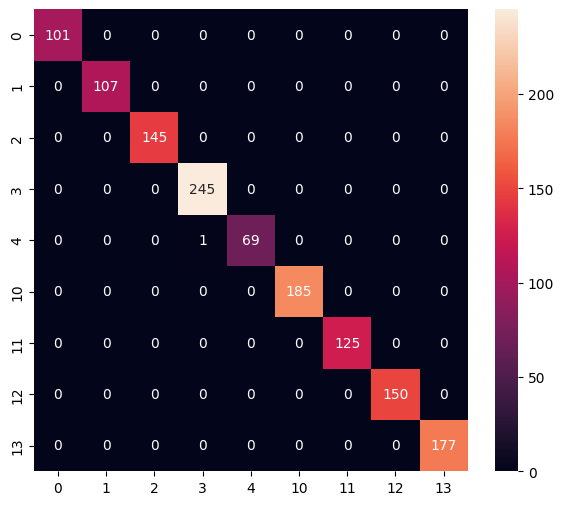

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       145
           3       1.00      1.00      1.00       245
           4       1.00      0.99      0.99        70
          10       1.00      1.00      1.00       185
          11       1.00      1.00      1.00       125
          12       1.00      1.00      1.00       150
          13       1.00      1.00      1.00       177

    accuracy                           1.00      1305
   macro avg       1.00      1.00      1.00      1305
weighted avg       1.00      1.00      1.00      1305



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/home/pavanmanishd/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpzro9gexy/assets


INFO:tensorflow:Assets written to: /tmp/tmpzro9gexy/assets
2023-10-07 12:11:00.136787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-07 12:11:00.136852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-07 12:11:00.143417: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzro9gexy
2023-10-07 12:11:00.144430: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-07 12:11:00.144484: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpzro9gexy
2023-10-07 12:11:00.155939: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-07 12:11:00.156827: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-10-07 12:11:00.250302: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

7544

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 38 µs, sys: 5 µs, total: 43 µs
Wall time: 46.3 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.76886451e-01 6.94974617e-04 1.65766451e-05 1.07733145e-11
 2.60642121e-08 1.17973274e-19 3.10344110e-20 2.59614125e-19
 4.01427575e-16 1.48031739e-16 5.14842168e-15 2.15493109e-11
 8.52538661e-19 2.24020071e-02]
0
